## Load in imports and data

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# NO_DATA investigation
import lsst.geom as geom

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

Confirm which version of packages are setup on the notebook environment.

In [4]:
# import lsst.pipe.tasks, lsst.drp.tasks, lsst.cell_coadds
# print(lsst.pipe.tasks.__file__)
# print(lsst.drp.tasks.__file__)
# print(lsst.cell_coadds.__file__)

In [2]:
# collection = 'u/mgorsuch/assemble_cell_coadd_patch_61/20240403T183342Z' # for the patch 61 collection, with 8 detected warps.
collection = 'u/mgorsuch/assemble_cell_coadd_patch_61_d0508/20240509T165409Z' # updated patch 61 collection

In [3]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i',)

In [4]:
stitch_coadd = coadd.stitch()

In [5]:
cell_list = list(coadd.cells.keys())

## 1D Cell Inputs

In [7]:
inputs_list = []
for cell in cell_list:
    cell_inputs = coadd.cells[cell].inputs
    inputs_list.append(len(cell_inputs))
inputs_list = np.array(inputs_list)

### Plotting cell input 1D histogram

(array([  0.,   9.,  21.,  71., 119.,  85.,  80.,  99.,   0.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

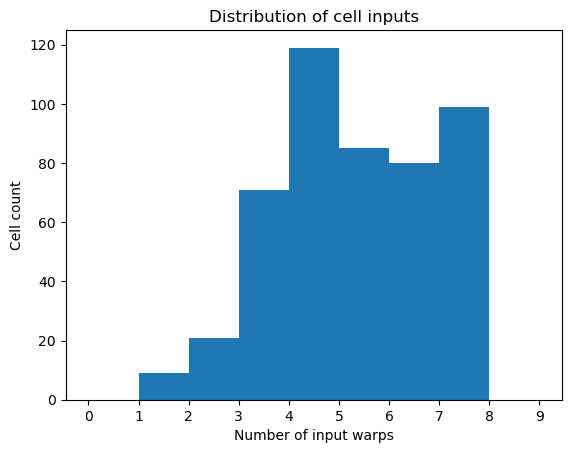

In [9]:
bins = np.arange(0, np.max(inputs_list)+3)
plt.xlabel("Number of input warps")
plt.ylabel("Cell count")
plt.title("Distribution of cell inputs")
plt.xticks(bins)
plt.hist(inputs_list, bins)

## Investigate NO_DATA

Find the cell that contains a large amount of NO_DATA masked pixels.
- The 2305, 715 coordinate is found using the Firefly display and hovering over the masked pixels. The readout option should be set to FITS Image Pixel. However, the coadd object does not have an origin at 0,0. This offset must be added, and is found using `getMin()` method.

In [37]:
print(coadd.grid.index(coadd.inner_bbox.getMin()+(geom.Extent2I(2305, 715))))

Index2D(x=15, y=4)


Alterate way to determine NO_MASK cell

In [12]:
print(coadd.grid.index(geom.Point2I(20105,15512)))

Index2D(x=15, y=4)


Find the input warps used in this cell:

In [13]:
cell_no_data = coadd.cells[Index2D(x=15, y=4)]
print(cell_no_data.inputs)

frozenset({ObservationIdentifiers(instrument='HSC', packed=4690, visit=19684, detector=50)})


Using the output above, read in the relevant warp:

In [14]:
# get the above warp with no_data from the butler
warp2 = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract=9813,
                   patch=61,
                   visit = 19684)

#### Compare the warp, stitiched coadd, and cell images

Read in the relevant warp and the cell with NO_DATA masked pixels:

In [32]:
cell_test = coadd.cells[Index2D(x=15, y=4)]

In [23]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp2.getMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=15, y=4)].inner.asMaskedImage())

Read in the stitched coadd and the cell with NO_DATA masked pixels:

In [175]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp2.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=0, y=0)].inner.variance)

In [92]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitch_coadd.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.cells[Index2D(x=15, y=4)].inner.asMaskedImage())

### Investigate NO_DATA in normal warping/coaddition process (none cell-based)
**TO-DO**: need to rerun with updated dataset types

Read in the relevant warp and coadd

## Plot mask information

There is probably a more efficient way to do this but this is for a first try

Text(0, 0.5, 'Cell count')

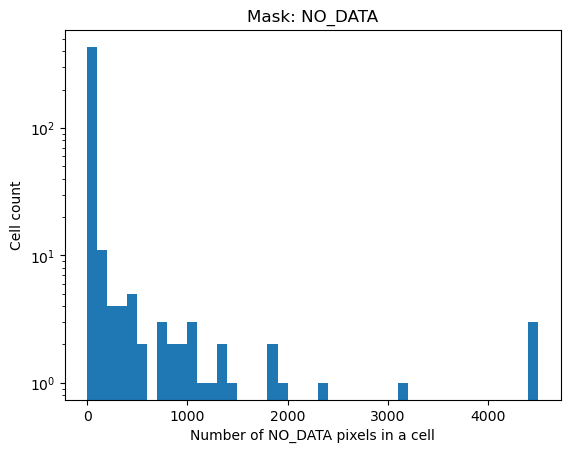

In [40]:
num_mask_pix = []
plot_mask = 'NO_DATA'
# for now assume the bit is the same for each cell, and use the bit from the first cell to avoid calling the bit number 400+ times
# TO-DO check that each cell uses the same bits for each mask
some_cell = cell_no_data = coadd.cells[Index2D(x=1, y=1)]
mask_bit = some_cell.inner.mask.getPlaneBitMask(plot_mask)

for cell_index in cell_list:
    
    cell_mask = coadd.cells[cell_index]
    num_bad_pixels = len(np.where(np.bitwise_and(cell_mask.inner.mask.array, mask_bit))[0])
    # optionally print cells that contain the defined masked pixels
    # if num_bad_pixels > 0:
    #     print(cell_index)
    num_mask_pix.append(num_bad_pixels)
    
num_mask_pix = np.array(num_mask_pix)

# plot data as a histogram
bins = np.arange(0, np.max(num_mask_pix)+1, 100)
plt.hist(num_mask_pix, bins)
plt.title(f"Mask: {plot_mask}")
plt.xlabel(f"Number of {plot_mask} pixels in a cell")
plt.yscale("log")
plt.ylabel("Cell count")

## Generate 2D histogram of number of cell inputs across patch 61

Generate an array of input data from each cell (this may need some fiddling with getting differing array structures to work together)

In [28]:
stitch_coadd.asExposure().getDimensions()

Extent2I(3400, 3400)

Get the grid structure of the stitched coadd:

In [29]:
print(stitch_coadd.grid)

UniformGrid(cell_size=Extent2I(150, 150), shape=(22, 22), min=Point2I(17850, 14850))


Arrange the number of inputs for each cell into a 2D grid:

In [10]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.empty([22,22])

for cell in cell_list:
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

Plot the 2D grid of cell inputs:

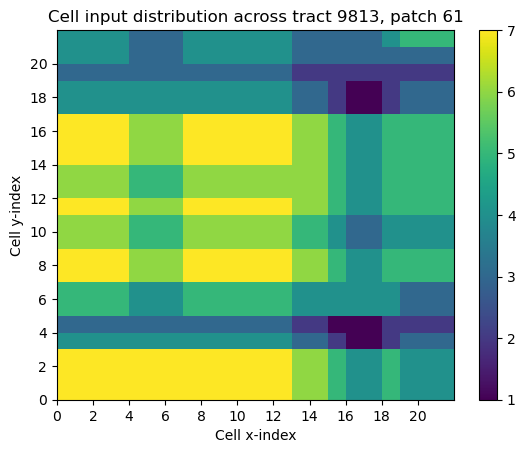

In [11]:
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21, 2))
plt.title("Cell input distribution across tract 9813, patch 61")
plt.xlabel("Cell x-index")
plt.ylabel("Cell y-index")
plt.colorbar()

Brief check that index of cells are lining up as expected

In [12]:
print(len(coadd.cells[Index2D(x=0, y=0)].inputs)) # expect 7
print(len(coadd.cells[Index2D(x=15, y=4)].inputs)) # expect 1
print(len(coadd.cells[Index2D(x=7, y=9)].inputs)) # expect 6

7
1
6


### Display above histogram over the stitched coadd

Maybe not as useful as I had hoped, but still an interesting exercise in manipulating array images.

In [41]:
import lsst.geom as afwGeom

In [42]:
flipped_stitch = np.flip(stitch_coadd.image.getArray(), axis=0)

Many different ways to retrieve the bounding box coordinates:

In [31]:
# coadd pixel coordinates for minimum corner and maximum corner
print(stitch_coadd.bbox)
# split up the four values
print(stitch_coadd.bbox.beginX)
print(stitch_coadd.bbox.beginY)
print(stitch_coadd.bbox.maxX)
print(stitch_coadd.bbox.maxY)
# get each corner
print(stitch_coadd.bbox.getBegin())
print(stitch_coadd.bbox.getMax())

(minimum=(17800, 14800), maximum=(21199, 18199))
17800
14800
21199
18199
(17800, 14800)
(21199, 18199)


Remove the image padding (50 pixels added to each side, actual image should be 3300x3300 pixels:

In [44]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
cutout = stitch_coadd.asExposure()[bbox]
print(cutout.getDimensions())

(3300, 3300)


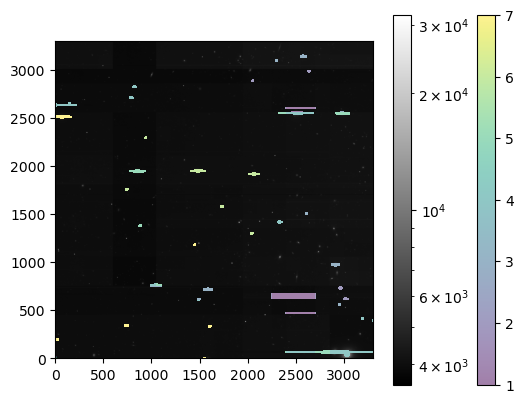

In [45]:
from matplotlib.colors import LogNorm
plt.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), alpha=0.5)
# extent = np.min(x), np.max(x), np.min(y), np.max(y)
extent = 0, 3300, 0, 3300
im1 = plt.imshow(np.flip(inputs_list, axis=0), alpha=0.5, extent=extent)
color1 = plt.colorbar(im1)
im2 = plt.imshow(np.flip(cutout.image.getArray(), axis=0), cmap='gray', norm=LogNorm(), extent=extent)
color2 = plt.colorbar(im2)
plt.show()

## Cell Variance Distribution (WIP)

### Plot 2D histogram of variance 
Mask cells with infinite/nan values

In [66]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

mask_mean_var_list = ma.masked_invalid(np.empty([22,22]))
mask_median_var_list = ma.masked_invalid(np.empty([22,22]))

for cell in cell_list:
    var_array = coadd.cells[cell].inner.variance.array

    x_index = cell.x
    y_index = cell.y

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        mask_mean_var_list[y_index][x_index] = var_array[0][0] # insert the invalid value of inf to be masked at bottom of the cell
        mask_median_var_list[y_index][x_index] = var_array[0][0]
        continue
    
    mean_var = np.mean(var_array[np.isfinite(var_array)])
    median_var = np.median(var_array[np.isfinite(var_array)])

    mask_mean_var_list[y_index][x_index] = mean_var
    mask_median_var_list[y_index][x_index] = median_var

mask_mean_var_list = ma.masked_invalid(mask_mean_var_list)
mask_median_var_list = ma.masked_invalid(mask_mean_var_list)

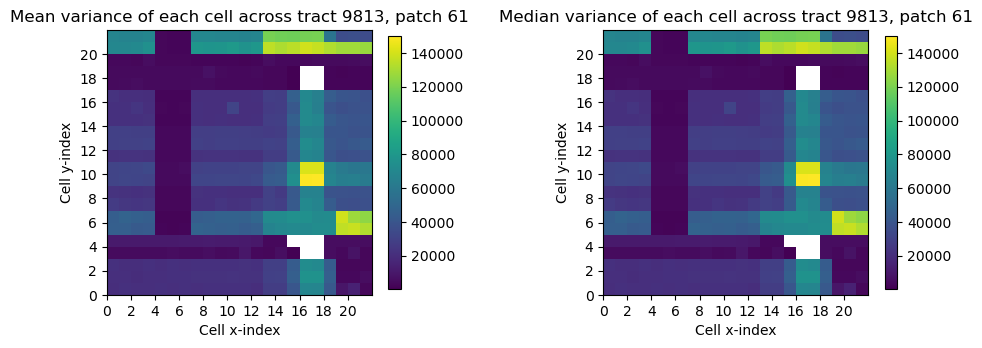

In [67]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

input_distrib = ax1.pcolormesh(mask_mean_var_list, 
                               shading='auto', 
                               vmin=ma.min(mask_mean_var_list[np.isfinite(mask_mean_var_list)]), 
                               vmax=ma.max(mask_mean_var_list[np.isfinite(mask_mean_var_list)]))
ax1.set_title("Mean variance of each cell across tract 9813, patch 61")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.3)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
                             shading='auto', 
                             vmin=ma.min(mask_median_var_list[np.isfinite(mask_median_var_list)]), 
                             vmax=ma.max(mask_median_var_list[np.isfinite(mask_median_var_list)]))
ax2.set_title("Median variance of each cell across tract 9813, patch 61")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.3)

plt.show()

### Compare cell input to cell variance

#### Compare the 2D histograms

First visually compare the two graphs

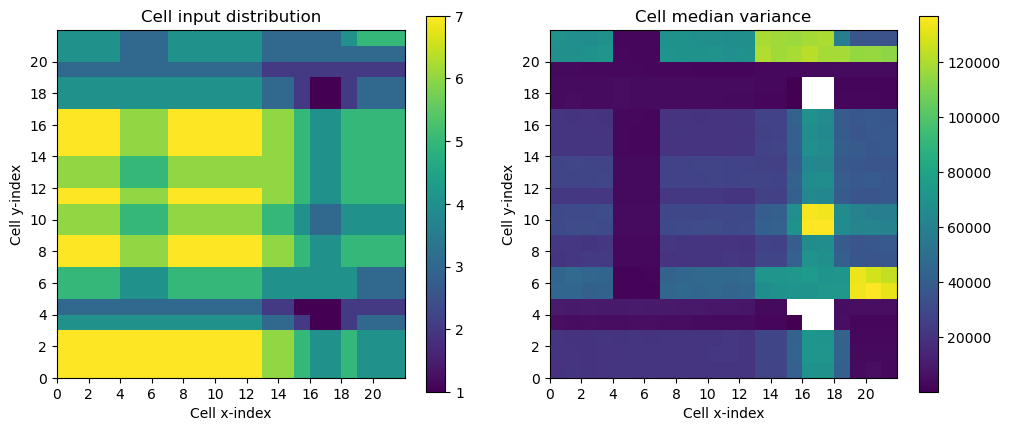

In [13]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
plt.tight_layout()

input_distrib = ax1.pcolormesh(x_cell_bin, y_cell_bin, inputs_list, shading='auto', vmin=inputs_list.min(), vmax=inputs_list.max(), linewidths=4)
ax1.set_title("Cell input distribution")
ax1.set_xlabel("Cell x-index")
ax1.set_ylabel("Cell y-index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))
fig.colorbar(input_distrib, ax=ax1, cmap='viridis', shrink=0.4)

var_distrib = ax2.pcolormesh(mask_median_var_list, 
               shading='auto', 
               vmin=ma.min(mask_median_var_list[np.isfinite(mask_median_var_list)]), 
               vmax=ma.max(mask_median_var_list[np.isfinite(mask_median_var_list)]),)
ax2.set_title("Cell median variance")
ax2.set_xlabel("Cell x-index")
ax2.set_ylabel("Cell y-index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))
fig.colorbar(var_distrib, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

### Verify weighted mean of the variance

Read in the weight of each cell using methods from `_compute_weight` in `assemble_cell_coadd`.

In [6]:
# create and configure stats control object as seen in assemble_cell_coadd
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

In [7]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1242  1248 19680 19684 19694 19696 30482 30490]


Iterate through the warps and their cells to determine several values for weighted means of the variance.
Only concerned with a single cell at a time for now.

In [8]:
accTask = AssembleCellCoaddTask()

weighted_var_list = []
var_coadd_list = []

var_test_cell = Index2D(x=0,y=0) # 15, 3 for negative var test

for warp_visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = 61,
                       visit = warp_visit)

    cell = coadd.cells[var_test_cell]
        
    # check if cell uses warp, skip cell if not
    cell_inputs = list(cell.inputs)
    cell_visits = [input.visit for input in cell_inputs]
    if not (np.isin(warp_visit, cell_visits)):
        continue
    
    x_index = var_test_cell.x
    y_index = var_test_cell.y
    
    bbox = cell.outer.bbox
    masked_im = warp[bbox].getMaskedImage()

    # compute weights from _compute_weight statistic
    computed_weight = accTask._compute_weight(masked_im, statsCtrl)
    
    # get the weighted var for this cell for a single pixel
    im_var_array_0 = masked_im.variance.array[0][0]
    weighted_var_list.append(computed_weight * im_var_array_0)
    # print(masked_im.mask.array[0][0] == 0) # check that the pixel doesn't have any masks (bit-value = 0)

    # get the weighted array of the variance
    weighted_var_array = computed_weight * masked_im.variance.array
    var_coadd_list.append(weighted_var_array)

    del warp

var_coadd_list = ma.masked_invalid(np.array(var_coadd_list))
var_coadd = np.nanmean(var_coadd_list, axis=0)

Compare the weighted sum from the input warps to the variance of that pixel to the cell.

0.96202743 12087.115 12087.115


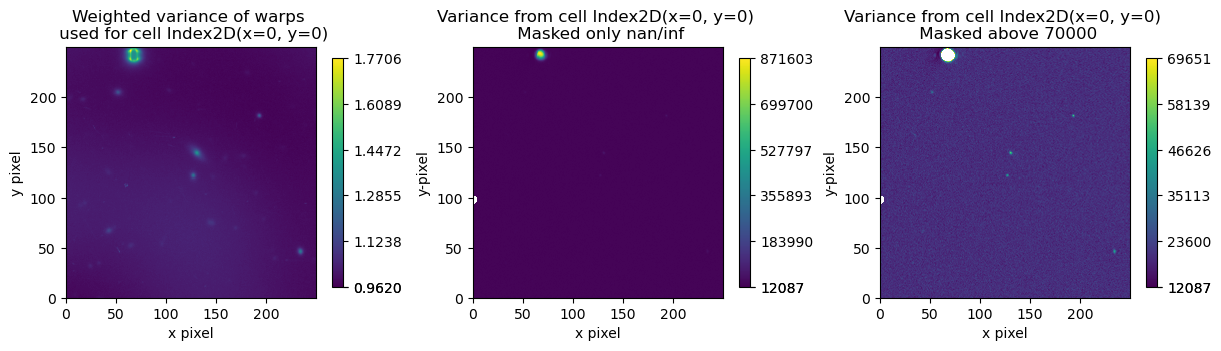

In [9]:
# get the variance from test cell
cell_0 = coadd.cells[var_test_cell]
var_0_all = ma.masked_invalid(np.array(cell_0.outer.variance.array))
var_0_small = ma.masked_greater_equal(var_0_all, 70000) # add additional mask to show range
print(var_coadd.min(), var_0_all.min(), var_0_small.min())

fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,12))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

warp_var_distrib = ax1.pcolormesh(var_coadd, 
                               shading='auto', 
                               vmin=var_coadd.min(), 
                               vmax=var_coadd.max(),)

ax1.set_title(f"Weighted variance of warps \n used for cell {var_test_cell}")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_coadd.min()
ticks1 = np.append(ticks1, np.linspace(var_coadd.min(), var_coadd.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_coadd.max())

fig.colorbar(warp_var_distrib, ax=ax1, cmap='viridis', shrink=0.2, ticks=ticks1)

cell_var_all = ax2.pcolormesh(var_0_all, 
                             shading='auto', 
                             vmin=var_0_all.min(), 
                             vmax=var_0_all.max(),)
ax2.set_title(f"Variance from cell {var_test_cell} \n Masked only nan/inf")
ax2.set_xlabel("x pixel")
ax2.set_ylabel("y-pixel")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 249, 50))
ax2.set_yticks(np.arange(0, 249, 50))
ticks2 = var_0_all.min()
ticks2 = np.append(ticks2, np.linspace(var_0_all.min(), var_0_all.max(), 5, endpoint=False))
ticks2 = np.append(ticks2, var_0_all.max())
fig.colorbar(cell_var_all, ax=ax2, cmap='viridis', shrink=0.2, ticks=ticks2)

cell_var_small = ax3.pcolormesh(var_0_small, 
                             shading='auto', 
                             vmin=var_0_small.min(),
                             vmax=var_0_small.max(),)
ax3.set_title(f"Variance from cell {var_test_cell} \n Masked above 70000")
ax3.set_xlabel("x pixel")
ax3.set_ylabel("y-pixel")
ax3.set_aspect('equal')
ax3.set_xticks(np.arange(0, 249, 50))
ax3.set_yticks(np.arange(0, 249, 50))
ticks3 = var_0_small.min()
ticks3 = np.append(ticks3, np.linspace(var_0_small.min(), var_0_small.max(), 5, endpoint=False))
ticks3 = np.append(ticks3, var_0_small.max())
fig.colorbar(cell_var_small, ax=ax3, cmap='viridis', shrink=0.2, ticks=ticks3)

plt.show()

#### Mask bit masks in cell variance plane

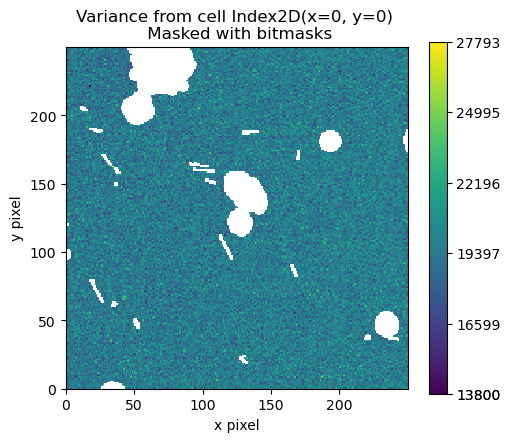

In [15]:
cell_0_mask = cell_0.outer.mask

# create masks (elements where the mask occurs are set to True)
var_mask_intrp = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("INTRP")), True, False)
var_mask_sat = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("SAT")), True, False)
var_mask_streak = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("STREAK")), True, False)
var_mask_suspect = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("SUSPECT")), True, False)
var_mask_cr = np.where(np.bitwise_and(cell_0_mask.array, cell_0_mask.getPlaneBitMask("CR")), True, False)
var_mask_nan = np.where(np.isfinite(cell_0.outer.variance.array), False, True)

# combine masks into a single mask. Any mask occuring will mask that element
all_mask = np.logical_or.reduce((var_mask_cr, var_mask_sat, var_mask_streak, var_mask_suspect, var_mask_cr, var_mask_nan))

# apply the mask to the variance plane of the cell
var_add_masks = ma.masked_array(cell_0.outer.variance.array, mask=all_mask)

fig,(ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

cell_add_masks = ax1.pcolormesh(var_add_masks, 
                               shading='auto', 
                               vmin=var_add_masks.min(), 
                               vmax=var_add_masks.max(),)

ax1.set_title(f"Variance from cell {var_test_cell} \n Masked with bitmasks")
ax1.set_xlabel("x pixel")
ax1.set_ylabel("y pixel")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 249, 50))
ax1.set_yticks(np.arange(0, 249, 50))
ticks1 = var_add_masks.min()
ticks1 = np.append(ticks1, np.linspace(var_add_masks.min(), var_add_masks.max(), 5, endpoint=False))
ticks1 = np.append(ticks1, var_add_masks.max())

fig.colorbar(cell_add_masks, ax=ax1, cmap='viridis', shrink=0.8, ticks=ticks1)
plt.show()

### Read in default coadds and look at variances

In [16]:
default_collection = 'u/mgorsuch/make_warp_61/20240508T162818Z'

In [17]:
default_coadd = butler.get('deepCoadd', 
                     collections=default_collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i',)

In [18]:
default_var = default_coadd.getVariance()
print(np.min(default_var.array))
print(np.max(default_var.array))
print(np.max(default_var.array[np.isfinite(default_var.array)]))

0.0009985425
inf
0.090337


### Look at cell images with 1 input warp (all infs values for variance)

In [19]:
inf_cell_list = np.array([[16,3],[17,3],[15,4],[16,4],[17,4],[16,17],[17,17],[16,18],[17,18]])

See if the same warp is used for all cells with 1 input

In [20]:
for cell_index in inf_cell_list:
    warp = list(coadd.cells[Index2D(x=cell_index[0],y=cell_index[1])].inputs)
    
    if len(warp)>1:
        print("over 1 warp")
        continue
    print(f"Cell index: {cell_index}, Input visit: {warp[0].visit}")

Cell index: [16  3], Input visit: 19684
Cell index: [17  3], Input visit: 19684
Cell index: [15  4], Input visit: 19684
Cell index: [16  4], Input visit: 19684
Cell index: [17  4], Input visit: 19684
Cell index: [16 17], Input visit: 19684
Cell index: [17 17], Input visit: 19684
Cell index: [16 18], Input visit: 19684
Cell index: [17 18], Input visit: 19684


In [32]:
no_data_warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = 61,
                       visit = 19684)

In [26]:
i=8
no_data_cell = coadd.cells[Index2D(x=inf_cell_list[i][0],y=inf_cell_list[i][1])]
bbox = no_data_cell.outer.bbox
masked_im = no_data_warp[bbox].getMaskedImage()

display1 = afwDisplay.Display(frame=1)
display1.mtv(no_data_cell.outer.variance)
display2 = afwDisplay.Display(frame=2)
display2.mtv(masked_im.image)

Note: all cells but 2 have the `NO_DATA` mask ([16,17] and [17,18] have only `CR`, `CROSSTALK`, `DETECTED`, and `INTRP`)

### Check DC2 run for interpolation errors in warps

In [26]:
REPO = '/sdf/data/rubin/repo/dc2/'
collection_dc2 = 'u/mgorsuch/assemble_cell_coadd_patch_61/20240509T184123Z'
butler = Butler(REPO)
registry = butler.registry

In [27]:
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', collections=collection_dc2):
    print(ref.dataId)

{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 162699, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193147, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193189, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193232, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193233, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 193888, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3828, patch: 42, visit: 202590, band: 'r', physical_filter: 'r_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2_cells_v1', tract: 3

In [47]:
warp_dc2 = butler.get('deepCoadd_directWarp',
                   collections = collection_dc2,
                   instrument='LSSTCam-imSim',
                   skymap = 'DC2_cells_v1',
                   tract = 3828,
                   patch = 42,
                   visit = 212071)

In [49]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(warp_dc2.maskedImage)